<a href="https://colab.research.google.com/github/KevinM11101005/YOLOv12/blob/main/train_yolov12_object_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = "XarTw09VRJncVEPwvwBe"

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Sat May 31 10:45:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 76.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg


--2025-05-31 10:47:28--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-05-31 10:47:28 (177 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 74.6MB/s]


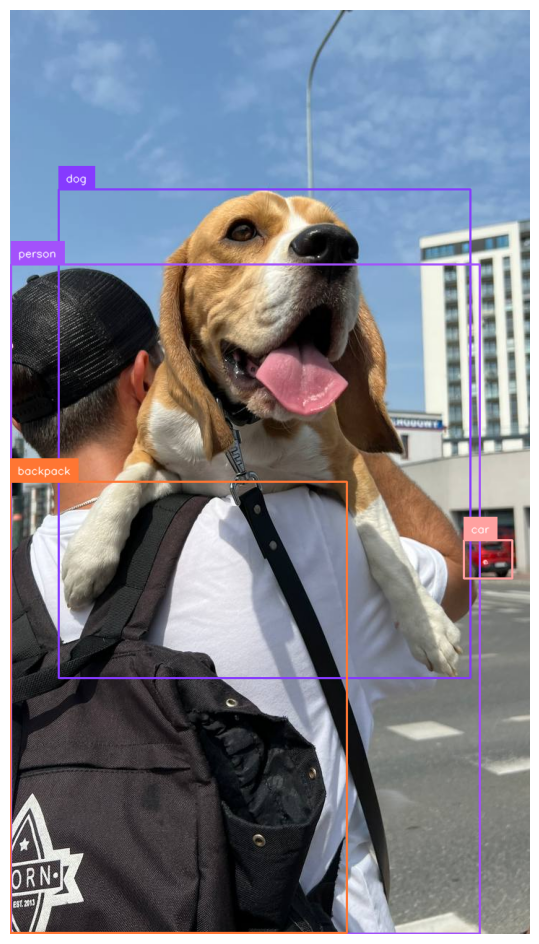

In [6]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [7]:
from roboflow import download_dataset
dataset = download_dataset('https://universe.roboflow.com/roboflow-100/road-signs-6ih4y/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to road-signs-2 in yolov8:: 100%|██████████| 4198/4198 [00:01<00:00, 3357.87it/s]


In [8]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [9]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [10]:
!cat {dataset.location}/data.yaml

names:
- bus_stop
- do_not_enter
- do_not_stop
- do_not_turn_l
- do_not_turn_r
- do_not_u_turn
- enter_left_lane
- green_light
- left_right_lane
- no_parking
- parking
- ped_crossing
- ped_zebra_cross
- railway_crossing
- red_light
- stop
- t_intersection_l
- traffic_light
- u_turn
- warning
- yellow_light
nc: 21
roboflow:
  license: CC BY 4.0
  project: road-signs-6ih4y
  url: https://universe.roboflow.com/roboflow-100/road-signs-6ih4y/dataset/2
  version: 2
test: ../test/images
train: ../train/images
val: ../valid/images


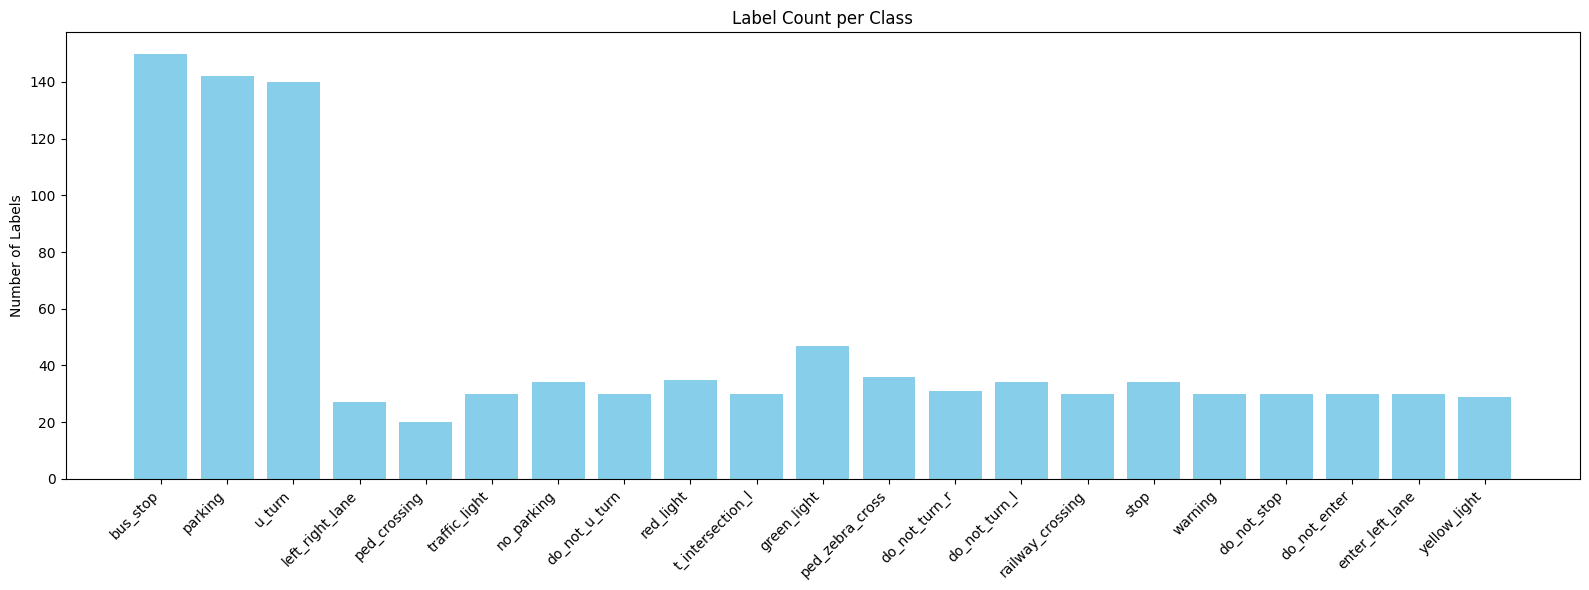

In [11]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# class names
names = [
    'bus_stop', 'do_not_enter', 'do_not_stop', 'do_not_turn_l', 'do_not_turn_r',
    'do_not_u_turn', 'enter_left_lane', 'green_light', 'left_right_lane', 'no_parking',
    'parking', 'ped_crossing', 'ped_zebra_cross', 'railway_crossing', 'red_light',
    'stop', 't_intersection_l', 'traffic_light', 'u_turn', 'warning', 'yellow_light'
]

# 路徑設定
split_dirs = ['/content/road-signs-2/test/labels', '/content/road-signs-2/valid/labels', '/content/road-signs-2/test/labels']
label_counts = defaultdict(int)

# 逐個資料夾讀取標註檔
for dir_path in split_dirs:
    if not os.path.exists(dir_path):
        continue
    for file_name in os.listdir(dir_path):
        if not file_name.endswith('.txt'):
            continue
        with open(os.path.join(dir_path, file_name), 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                label_counts[class_id] += 1

# 將 class_id 映射為名字
category_counts = {names[class_id]: count for class_id, count in label_counts.items()}

# 確保所有類別都顯示（即使為 0）
for name in names:
    category_counts.setdefault(name, 0)

# 畫直方圖
plt.figure(figsize=(16, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Labels")
plt.title("Label Count per Class")
plt.tight_layout()
plt.show()

## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=200)

New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/road-signs-2/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

100%|██████████| 755k/755k [00:00<00:00, 35.4MB/s]


Overriding model.yaml nc=80 with nc=21

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 131MB/s]


AMP: checks passed ✅


train: Scanning /content/road-signs-2/train/labels... 1376 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1376/1376 [00:00<00:00, 2400.29it/s]

train: New cache created: /content/road-signs-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/road-signs-2/valid/labels... 488 images, 0 backgrounds, 0 corrupt: 100%|██████████| 488/488 [00:00<00:00, 1130.05it/s]


val: New cache created: /content/road-signs-2/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      6.75G      3.182      5.806       4.26         38        640: 100%|██████████| 86/86 [00:50<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]

                   all        488        529          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      6.86G      3.074       5.64      4.046         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


                   all        488        529      0.185      0.072    0.00871    0.00275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      6.86G      2.924      5.235      3.617         41        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


                   all        488        529      0.188       0.15     0.0226    0.00826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      6.86G      2.673      4.634      3.162         29        640: 100%|██████████| 86/86 [00:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


                   all        488        529      0.232      0.224      0.165     0.0765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      6.86G      2.365      4.037      2.769         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


                   all        488        529      0.345      0.343       0.28      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      6.86G      2.165      3.635      2.531         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


                   all        488        529      0.378      0.372      0.329      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      6.86G      1.961      3.242      2.369         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


                   all        488        529      0.347      0.433      0.385       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      6.86G      1.851      2.987      2.224         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


                   all        488        529      0.407      0.427      0.417      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      6.86G      1.666      2.752      2.109         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        488        529      0.525      0.456      0.455      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      6.87G      1.604      2.598      2.021         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


                   all        488        529      0.428      0.564      0.506      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      6.86G      1.547      2.461      1.955         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]

                   all        488        529      0.477      0.508      0.508      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      6.86G      1.479      2.332      1.897         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all        488        529      0.502      0.528      0.535      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      6.86G      1.407       2.22      1.837         40        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]

                   all        488        529      0.487      0.559      0.551       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      6.86G      1.398      2.163      1.816         31        640: 100%|██████████| 86/86 [00:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529      0.431      0.616       0.55      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      6.86G      1.403       2.11      1.805         24        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]


                   all        488        529      0.527      0.583      0.585      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      6.86G      1.358      2.048      1.768         30        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.519      0.577      0.576      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      6.86G      1.289      1.939      1.709         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


                   all        488        529      0.599      0.598      0.653      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      6.86G      1.291       1.86      1.721         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529      0.563      0.619      0.625      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      6.86G      1.239      1.804      1.658         27        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.515      0.686       0.65      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      6.86G      1.237      1.766      1.645         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all        488        529       0.53       0.64      0.628      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      6.86G      1.222      1.739      1.627         27        640: 100%|██████████| 86/86 [00:47<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all        488        529      0.603      0.678      0.702      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200       6.7G      1.178      1.669      1.593         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.598      0.653      0.677      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      6.69G      1.197      1.647      1.609         37        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


                   all        488        529      0.649      0.719      0.715      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200       6.7G      1.164      1.596       1.58         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all        488        529      0.612      0.727      0.722       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200       6.7G      1.127      1.569      1.563         41        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all        488        529      0.734      0.693      0.757      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200       6.7G      1.142      1.518      1.554         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.676      0.724      0.746      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      6.69G      1.138      1.492      1.543         40        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


                   all        488        529      0.717      0.752      0.784      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       6.7G      1.117      1.495      1.535         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all        488        529      0.757      0.779       0.81      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200       6.7G      1.097      1.411      1.496         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all        488        529      0.739      0.774       0.81      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200       6.7G      1.075      1.397      1.491         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all        488        529        0.7        0.8      0.796      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200       6.7G      1.062      1.383      1.497         31        640: 100%|██████████| 86/86 [00:47<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.811      0.764      0.814      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      6.86G      1.055      1.321       1.47         22        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.833      0.802      0.848      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      6.86G      1.072      1.318      1.485         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all        488        529      0.756      0.786      0.826      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      6.86G      1.056      1.306      1.475         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all        488        529      0.813      0.801      0.854      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      6.87G      1.035      1.272      1.451         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529        0.8      0.779      0.842       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      6.84G      1.028      1.243      1.435         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.857      0.781      0.858      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      6.86G      1.032       1.25      1.442         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all        488        529      0.829      0.808      0.867      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      6.87G      1.027      1.237      1.441         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]

                   all        488        529      0.886      0.777      0.866      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      6.86G      1.041       1.25      1.455         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all        488        529      0.856      0.832      0.886      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      6.86G      0.996      1.153      1.409         28        640: 100%|██████████| 86/86 [00:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.871      0.802      0.869      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      6.86G      1.011      1.184      1.417         39        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.855      0.817      0.882       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      6.86G     0.9803      1.161      1.406         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all        488        529      0.909      0.801      0.882      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      6.69G     0.9888      1.135      1.403         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.853       0.82      0.886      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      6.86G     0.9663      1.106      1.386         28        640: 100%|██████████| 86/86 [00:47<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529      0.853      0.838      0.888      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      6.69G      0.961      1.125      1.391         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.893       0.83      0.907      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      6.86G     0.9591      1.083      1.386         23        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all        488        529       0.91      0.822      0.898      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      6.68G       0.97      1.086      1.382         30        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all        488        529      0.885      0.797       0.88      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      6.86G     0.9641      1.083      1.398         38        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]

                   all        488        529      0.858      0.835      0.894      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      6.86G     0.9374      1.042      1.363         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.884      0.848      0.899      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200       6.7G     0.9297      1.038      1.355         28        640: 100%|██████████| 86/86 [00:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        488        529      0.904      0.831      0.911      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200       6.7G     0.9336       1.02      1.355         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


                   all        488        529      0.865       0.86      0.908      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      6.86G     0.9301      1.025      1.359         27        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all        488        529      0.859      0.842      0.901       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      6.86G     0.9017      1.003      1.335         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]

                   all        488        529      0.863      0.854      0.902      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200       6.7G     0.9303      1.008      1.348         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.892      0.863      0.908      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200       6.7G     0.8976     0.9923      1.324         38        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.876      0.855      0.919       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200       6.7G     0.9216      1.021      1.344         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        488        529      0.842      0.836      0.893      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200       6.7G     0.9021     0.9742      1.325         42        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


                   all        488        529      0.905      0.841      0.918       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      6.69G     0.9189     0.9695      1.328         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.881       0.87      0.921       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      6.86G     0.9128     0.9762      1.337         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all        488        529       0.91      0.849      0.918      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      6.86G      0.901     0.9824      1.338         39        640: 100%|██████████| 86/86 [00:47<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.914      0.853      0.922      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      6.86G     0.8917     0.9418      1.318         26        640: 100%|██████████| 86/86 [00:47<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.863      0.864      0.906       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      6.86G     0.8836      0.915      1.308         27        640: 100%|██████████| 86/86 [00:47<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


                   all        488        529      0.893      0.874      0.922      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      6.86G     0.8659     0.9074      1.283         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.879      0.853      0.905      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      6.86G     0.8981     0.9288      1.321         30        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all        488        529      0.866      0.886      0.924       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      6.86G     0.8854     0.9156      1.313         20        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all        488        529      0.898      0.876      0.925      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      6.86G     0.8595     0.8993      1.292         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]

                   all        488        529       0.89       0.88      0.924      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      6.86G     0.8803     0.8934      1.306         32        640: 100%|██████████| 86/86 [00:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all        488        529      0.862      0.881      0.922      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      6.86G     0.8827     0.9176      1.311         37        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all        488        529      0.899      0.869      0.932      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      6.86G     0.8658     0.8738       1.29         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all        488        529      0.901      0.886      0.934      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      6.86G      0.856     0.8721      1.289         23        640: 100%|██████████| 86/86 [00:47<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all        488        529      0.898       0.88      0.929      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      6.86G     0.8423     0.8519      1.275         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.877      0.882      0.925      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      6.86G     0.8617     0.8705      1.302         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.914      0.873      0.931      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      6.86G     0.8448     0.8686      1.279         40        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all        488        529      0.876      0.891      0.925       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      6.86G     0.8483     0.8519      1.278         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.29it/s]

                   all        488        529      0.865      0.902       0.93      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      6.86G     0.8392       0.84      1.265         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all        488        529      0.878      0.868      0.925       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      6.86G     0.8345      0.837      1.257         32        640: 100%|██████████| 86/86 [00:47<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529      0.919      0.885       0.93      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200       6.7G     0.8336     0.8427      1.273         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.876      0.881      0.926      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      6.86G     0.8157     0.8053      1.248         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all        488        529      0.903      0.879      0.928      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      6.86G     0.8609     0.8501      1.293         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]

                   all        488        529      0.891      0.883      0.932      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      6.86G     0.8202     0.8262      1.269         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.895      0.893      0.939       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      6.86G     0.8194     0.8139      1.259         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all        488        529      0.932      0.887      0.943      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      6.86G     0.8065     0.7879      1.254         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]

                   all        488        529       0.91      0.876      0.925      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      6.86G     0.8204      0.821      1.251         32        640: 100%|██████████| 86/86 [00:47<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all        488        529      0.878      0.887       0.93      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      6.86G     0.8113     0.8241      1.238         39        640: 100%|██████████| 86/86 [00:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529      0.942      0.868      0.942      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      6.69G     0.8183     0.8141      1.258         38        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all        488        529      0.934      0.875      0.935      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      6.86G     0.8052     0.7834      1.244         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all        488        529      0.895      0.903      0.943      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      6.86G     0.8182     0.8185      1.239         41        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.28it/s]

                   all        488        529      0.902      0.876       0.93      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      6.86G     0.8016     0.7869      1.237         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all        488        529      0.939      0.861      0.929      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      6.86G     0.8054      0.765      1.248         30        640: 100%|██████████| 86/86 [00:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all        488        529      0.911      0.895       0.94      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      6.86G     0.7783     0.7546      1.231         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.904      0.888      0.927      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      6.86G     0.7823     0.7607      1.223         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]


                   all        488        529      0.921      0.888      0.942      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      6.86G     0.8004     0.7732      1.236         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.906      0.891      0.931      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200       6.7G     0.7886     0.7633      1.225         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all        488        529      0.891      0.865      0.929      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       6.7G     0.8001     0.7761      1.238         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        488        529      0.926      0.881      0.933      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      6.86G     0.7923     0.7635      1.224         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        488        529      0.927      0.909      0.952      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      6.86G     0.7901     0.7488      1.225         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


                   all        488        529      0.948      0.889      0.945      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      6.86G     0.7716     0.7456      1.218         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all        488        529      0.942      0.884      0.942      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      6.86G     0.8026     0.7675      1.229         22        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]

                   all        488        529      0.927      0.885      0.934      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      6.86G     0.7632     0.7378       1.21         41        640: 100%|██████████| 86/86 [00:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]

                   all        488        529      0.957       0.88      0.939      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      6.86G     0.7736     0.7484      1.217         40        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all        488        529      0.926      0.877      0.939       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200       6.7G     0.7796     0.7395      1.223         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


                   all        488        529      0.911      0.875      0.929      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200       6.7G      0.759       0.73      1.197         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]

                   all        488        529      0.934      0.885      0.932       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200       6.7G     0.7746     0.7418      1.219         38        640: 100%|██████████| 86/86 [00:50<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.904      0.891      0.937      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200       6.7G     0.7578     0.7311      1.209         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.934      0.911      0.947      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      6.86G     0.7818     0.7428      1.208         30        640: 100%|██████████| 86/86 [00:47<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


                   all        488        529      0.951      0.888      0.944      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200       6.7G      0.749     0.7024       1.19         30        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]

                   all        488        529      0.902      0.906       0.94      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      6.86G     0.7869     0.7386      1.222         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.912      0.887       0.94       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      6.69G     0.7649     0.7405      1.213         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.911      0.908      0.939      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      6.86G     0.7588       0.72      1.202         37        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.917      0.906      0.942       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      6.86G     0.7668     0.6937        1.2         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


                   all        488        529      0.934      0.885      0.941      0.769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      6.86G     0.7612     0.7102      1.197         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all        488        529       0.95      0.891      0.942      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      6.69G     0.7304       0.68       1.18         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all        488        529      0.949      0.897      0.941      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      6.86G      0.729     0.6937      1.181         33        640: 100%|██████████| 86/86 [00:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529      0.957      0.879      0.939       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      6.86G     0.7532     0.7048      1.203         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        488        529      0.918      0.889       0.94      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      6.69G     0.7389     0.6943      1.183         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


                   all        488        529      0.915      0.912      0.942      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      6.69G     0.7325     0.6842      1.185         38        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]

                   all        488        529       0.92      0.889      0.946      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200       6.7G     0.7347     0.6861      1.186         27        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529      0.934      0.896      0.944       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200       6.7G     0.7432      0.674      1.185         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.908      0.908      0.946      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200       6.7G     0.7436     0.6941      1.186         26        640: 100%|██████████| 86/86 [00:47<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.908      0.915      0.949      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200       6.7G       0.74     0.6896      1.177         24        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all        488        529      0.917      0.924       0.95      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200       6.7G      0.729     0.6835      1.184         46        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.927      0.891      0.939      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200       6.7G      0.734     0.6813      1.185         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.885      0.902      0.936      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      6.69G     0.7604     0.6782      1.198         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all        488        529      0.897      0.908      0.939      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      6.68G     0.7285     0.6994       1.19         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


                   all        488        529      0.927      0.892      0.942      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200       6.7G     0.7432     0.6788      1.188         27        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


                   all        488        529      0.923      0.903      0.943      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      6.86G     0.7206     0.6833       1.17         38        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        488        529      0.903      0.908      0.946      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      6.69G     0.7252     0.6843      1.177         40        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.931        0.9      0.942      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      6.69G     0.7269      0.661      1.181         37        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        488        529      0.931      0.882      0.936       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      6.86G     0.7176     0.6525      1.164         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all        488        529      0.922      0.896      0.939       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200       6.7G      0.727     0.6619      1.179         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all        488        529      0.948      0.902       0.95      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      6.86G     0.7496     0.6745      1.185         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all        488        529        0.9      0.914      0.945      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      6.69G     0.7088     0.6459      1.156         20        640: 100%|██████████| 86/86 [00:47<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.928       0.89      0.942      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      6.86G     0.7202     0.6418      1.174         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all        488        529      0.917      0.887      0.941      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200       6.7G      0.706     0.6469      1.158         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all        488        529      0.932      0.896      0.942      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      6.86G        0.7     0.6376      1.158         39        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all        488        529      0.927      0.896       0.94      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      6.69G     0.7263     0.6446      1.171         37        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529       0.93      0.891      0.938      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      6.86G      0.699     0.6254      1.154         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        488        529       0.93       0.89      0.938      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200       6.7G     0.6979     0.6201      1.152         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


                   all        488        529      0.944      0.897      0.941      0.786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      6.86G     0.7129     0.6606      1.162         36        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all        488        529      0.939      0.901      0.943      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200       6.7G     0.6992     0.6372      1.152         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.943        0.9      0.936      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      6.86G     0.7047     0.6474      1.151         37        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        488        529      0.914      0.923      0.943      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200       6.7G     0.7042     0.6463      1.161         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.908      0.916      0.942      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      6.86G     0.6916     0.6219      1.144         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]


                   all        488        529      0.935      0.898      0.942      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200       6.7G      0.698     0.6282      1.142         43        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.928        0.9      0.938      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      6.86G     0.6952     0.6237      1.154         35        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.932      0.893      0.937       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200       6.7G     0.7052     0.6313      1.153         41        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all        488        529       0.92       0.92       0.94      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      6.86G     0.6729     0.6263      1.139         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529      0.937      0.899      0.944       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      6.69G     0.7005     0.6147      1.142         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all        488        529      0.939      0.906      0.947       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      6.86G     0.6883     0.6349      1.153         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all        488        529      0.919      0.907      0.944      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200       6.7G     0.6818     0.6099       1.13         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.917       0.92      0.946      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      6.86G     0.6772       0.62      1.137         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all        488        529       0.93      0.916      0.943      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      6.69G     0.6983     0.6201      1.145         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all        488        529      0.932      0.922      0.947       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      6.86G     0.6788     0.6047      1.143         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


                   all        488        529      0.931      0.919      0.952      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200       6.7G     0.6655     0.5956      1.126         43        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all        488        529      0.925      0.924      0.949      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      6.86G     0.6824      0.625      1.146         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        488        529      0.934      0.917      0.949      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      6.69G      0.671     0.5915      1.133         30        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529      0.933      0.906      0.944      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      6.69G     0.6778     0.6095      1.139         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.938      0.909      0.945      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      6.86G     0.6565     0.5828      1.123         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all        488        529       0.93      0.908      0.946      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      6.69G     0.6758     0.6099      1.138         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]

                   all        488        529      0.938      0.904      0.946      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200       6.7G     0.6688     0.6023      1.132         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]

                   all        488        529      0.926      0.913      0.944      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      6.86G     0.6694     0.6012      1.131         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all        488        529      0.933      0.909      0.946       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      6.69G      0.664     0.5961      1.133         42        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


                   all        488        529      0.944       0.91       0.95      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      6.86G     0.6639     0.5829       1.13         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all        488        529      0.936      0.916      0.948      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200       6.7G     0.6788     0.6049      1.139         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all        488        529      0.937      0.907      0.945      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      6.86G     0.6568     0.5731      1.125         26        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.943      0.909      0.948      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200       6.7G     0.6622     0.5883      1.126         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.931      0.909      0.945      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      6.86G     0.6581     0.5833      1.135         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all        488        529      0.947      0.902      0.946      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      6.86G     0.6604     0.5829       1.12         25        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all        488        529      0.945      0.912      0.949      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      6.68G     0.6519     0.5829      1.116         44        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.942      0.911      0.945      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      6.86G     0.6671     0.5845      1.121         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.937      0.909      0.945      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      6.86G       0.66     0.5859       1.12         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]

                   all        488        529      0.943      0.898      0.944      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      6.86G     0.6424     0.5829      1.118         22        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all        488        529      0.935      0.913      0.947      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200       6.7G     0.6623     0.5865      1.133         33        640: 100%|██████████| 86/86 [00:47<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        488        529      0.944      0.902      0.945      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      6.69G      0.635     0.5691       1.12         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.959      0.897      0.948      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      6.86G     0.6396     0.5653      1.107         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all        488        529      0.939      0.906      0.948      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      6.86G     0.6609     0.5809      1.118         27        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


                   all        488        529      0.924      0.914      0.946      0.787

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      6.69G     0.6421     0.5604      1.118         31        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all        488        529      0.938      0.909      0.948      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200       6.7G     0.6518     0.5775       1.12         28        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all        488        529      0.938      0.908      0.946      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      6.68G     0.6285     0.5528      1.098         35        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        488        529      0.939      0.909      0.948      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200       6.7G     0.6656     0.5817      1.125         39        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all        488        529       0.94      0.908      0.948      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      6.86G     0.6354     0.5608      1.107         30        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.942       0.91      0.945      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      6.86G     0.6303     0.5522      1.102         38        640: 100%|██████████| 86/86 [00:46<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all        488        529       0.93      0.917      0.945      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      6.86G     0.6333     0.5604      1.108         34        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]

                   all        488        529       0.94      0.907      0.945      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200       6.7G     0.6438     0.5658      1.102         33        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        488        529      0.945      0.911      0.947      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200       6.7G      0.632     0.5628      1.102         31        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        488        529      0.936      0.902      0.944      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      6.86G     0.6297     0.5642        1.1         29        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        488        529      0.948      0.902      0.943      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200       6.7G     0.6337     0.5738      1.113         25        640: 100%|██████████| 86/86 [00:47<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all        488        529      0.928       0.91      0.942       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200       6.7G     0.6336     0.5729      1.113         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.934       0.91      0.945      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200       6.7G     0.6257     0.5619      1.103         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all        488        529      0.928      0.917      0.945      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      6.69G     0.6266     0.5632      1.103         32        640: 100%|██████████| 86/86 [00:46<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all        488        529      0.919      0.915      0.941      0.786


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      6.68G     0.5169     0.3914     0.9998         16        640: 100%|██████████| 86/86 [00:48<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


                   all        488        529      0.936      0.904      0.944      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      6.68G     0.5016     0.3657     0.9811         18        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all        488        529       0.94      0.903      0.947       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      6.68G     0.5027     0.3551     0.9808         17        640: 100%|██████████| 86/86 [00:45<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]

                   all        488        529      0.927      0.908      0.946      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      6.68G     0.4999     0.3665      0.993         19        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.952      0.899      0.945      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      6.68G     0.4961     0.3527     0.9793         19        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all        488        529      0.949      0.905      0.947      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      6.68G     0.4945     0.3538     0.9862         19        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


                   all        488        529      0.951      0.906      0.948      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      6.84G     0.4953     0.3491     0.9798         18        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all        488        529      0.952      0.901      0.948      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      6.84G      0.486     0.3518     0.9737         16        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]

                   all        488        529      0.945      0.905      0.946      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      6.68G     0.4871     0.3553     0.9763         16        640: 100%|██████████| 86/86 [00:46<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all        488        529      0.932      0.919      0.947      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      6.68G     0.4958     0.3532     0.9843         18        640: 100%|██████████| 86/86 [00:46<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        488        529      0.951      0.905      0.948      0.792



200 epochs completed in 3.022 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,082,335 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]


                   all        488        529      0.935      0.916      0.948      0.796
          do_not_enter         30         30      0.974      0.967      0.982      0.893
           do_not_stop         30         30      0.931        0.9      0.963      0.878
         do_not_turn_l         30         34      0.976      0.971      0.994      0.897
         do_not_turn_r         30         31      0.816      0.935      0.956      0.903
         do_not_u_turn         30         30      0.875      0.867      0.882      0.766
       enter_left_lane         30         30      0.955          1      0.987      0.882
           green_light         30         47      0.916      0.957      0.958      0.754
       left_right_lane          9          9       0.94          1      0.995      0.947
            no_parking         30         34      0.962      0.748      0.928      0.807
       ped_zebra_cross         30         36      0.985          1      0.995      0.811
      railway_crossin

## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   train_batch16340.jpg
confusion_matrix_normalized.png			   train_batch16341.jpg
confusion_matrix.png				   train_batch16342.jpg
events.out.tfevents.1748688493.f5d6bc1859a2.280.0  train_batch1.jpg
F1_curve.png					   train_batch2.jpg
labels_correlogram.jpg				   val_batch0_labels.jpg
labels.jpg					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


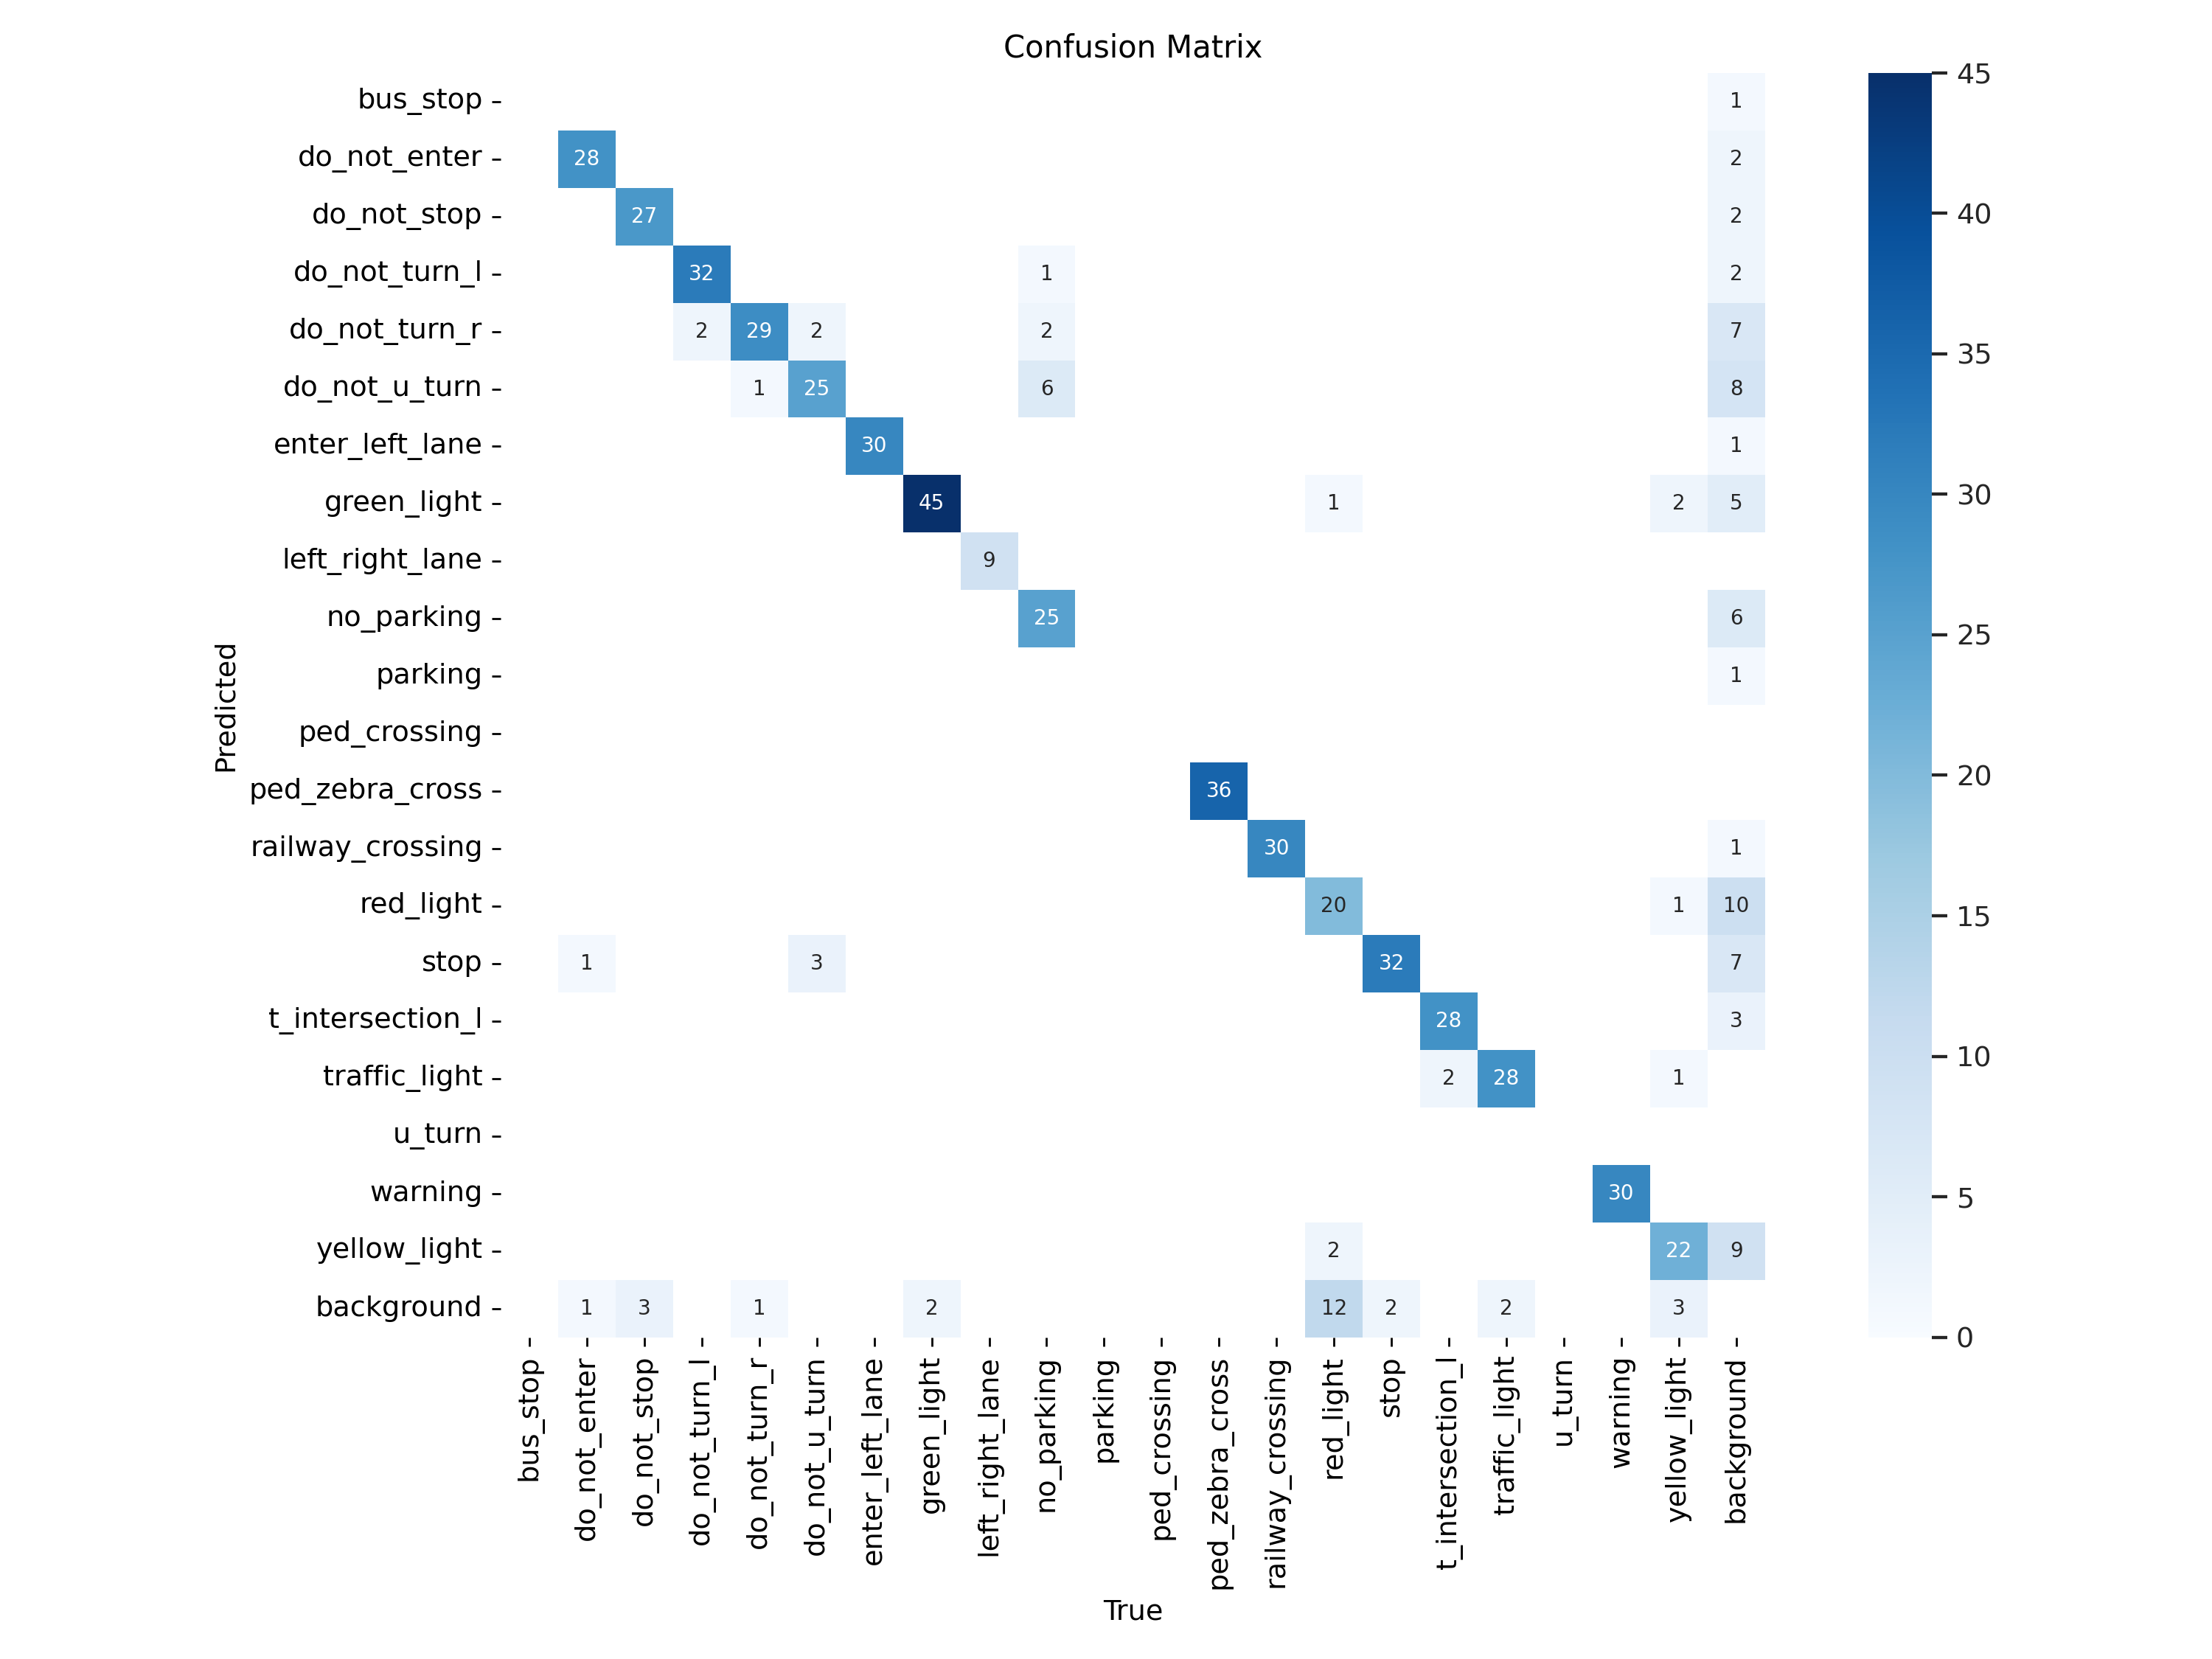

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

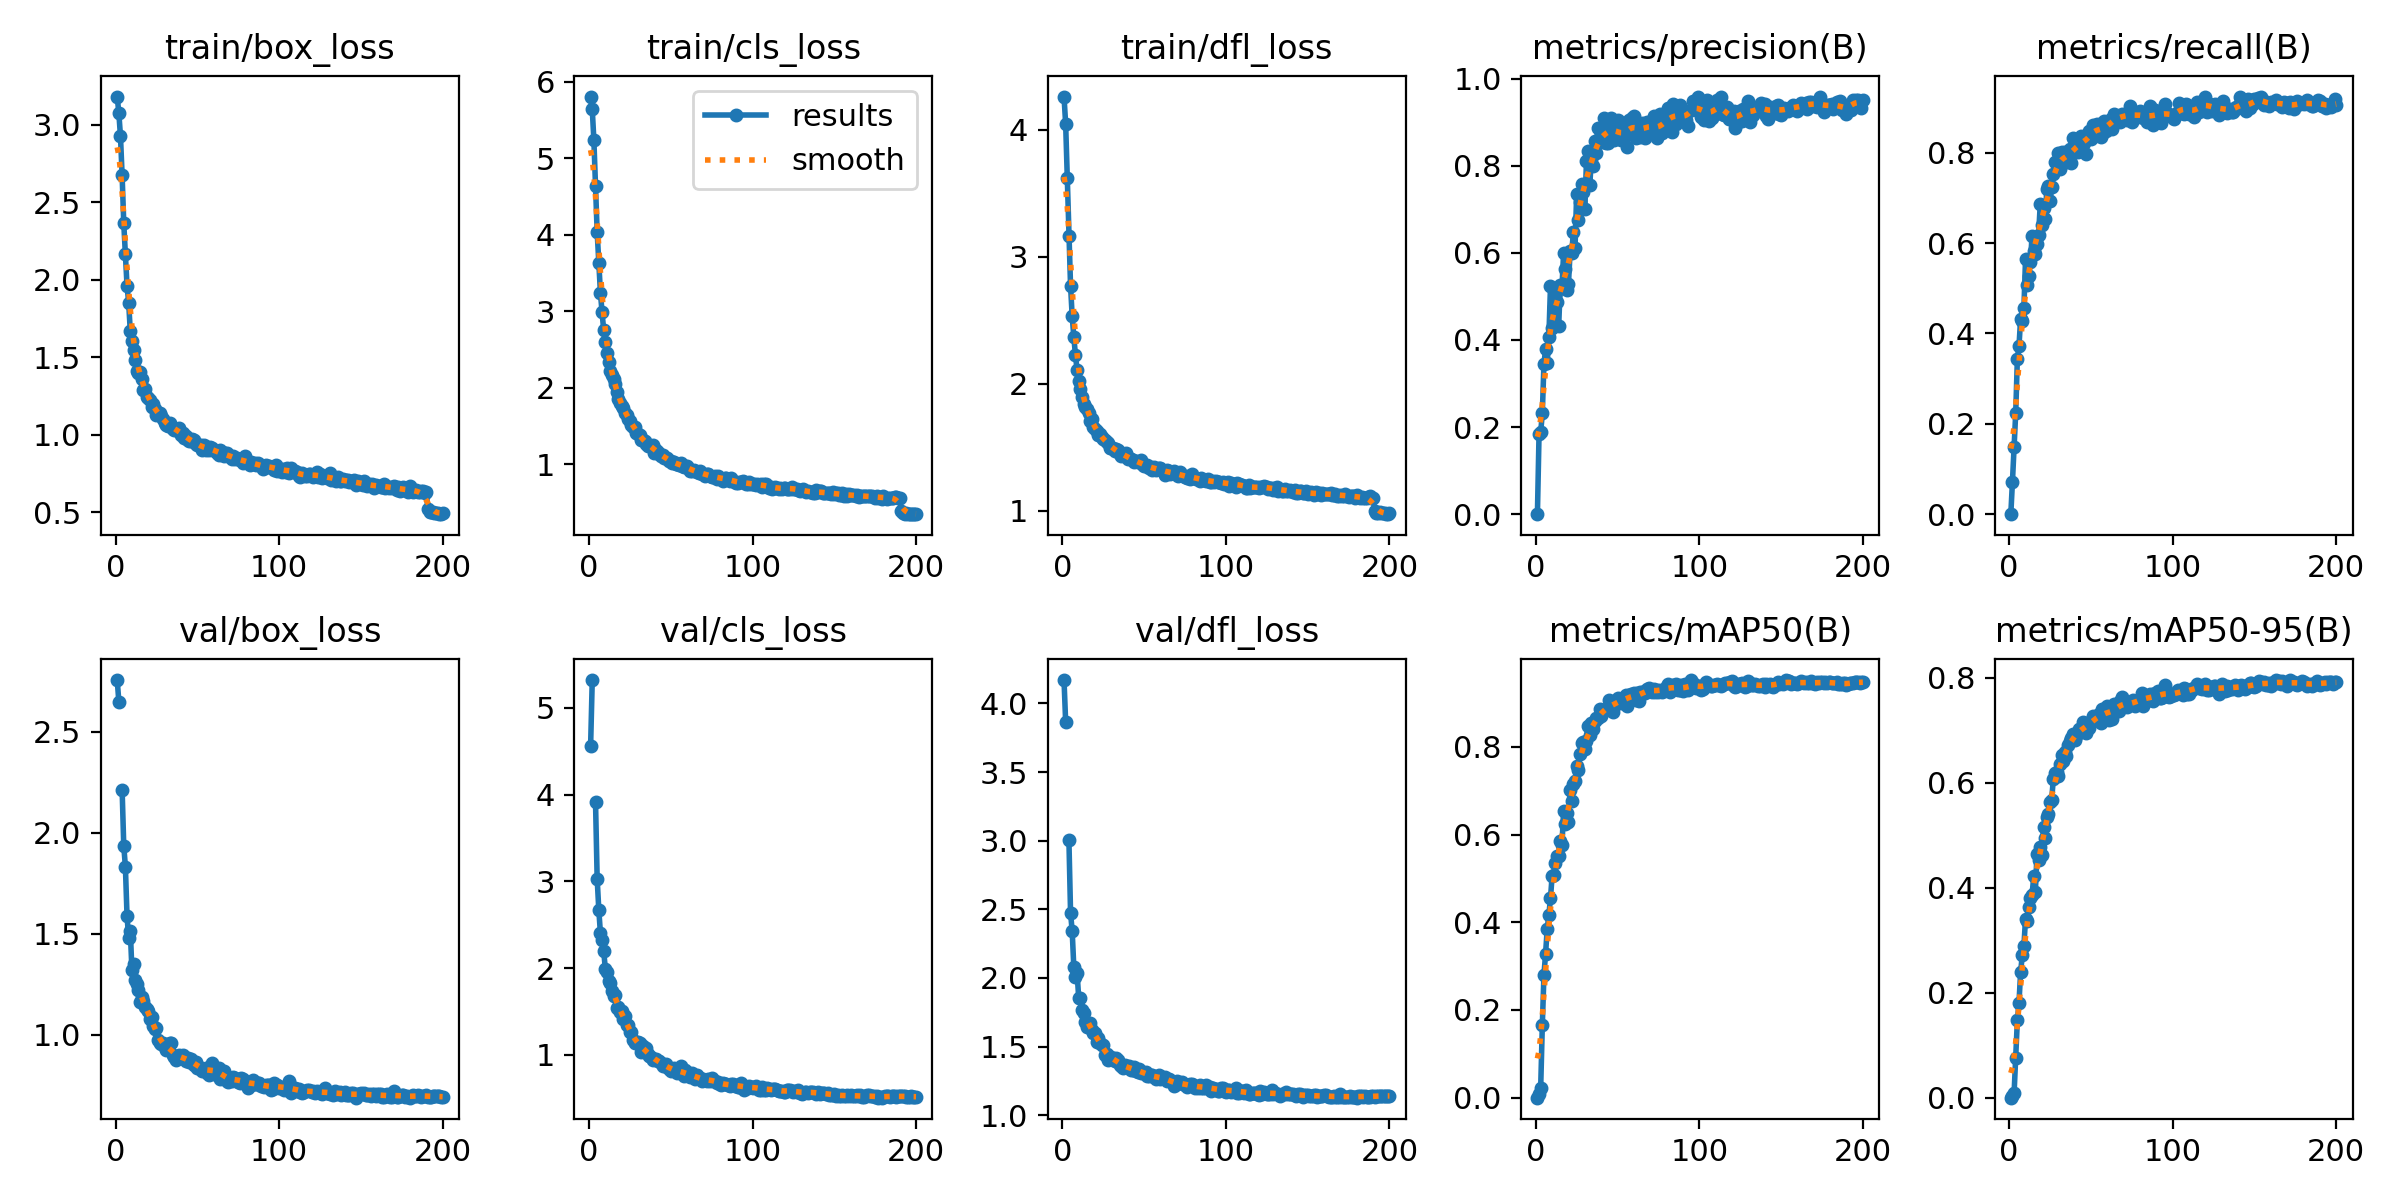

In [15]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['bus_stop',
 'do_not_enter',
 'do_not_stop',
 'do_not_turn_l',
 'do_not_turn_r',
 'do_not_u_turn',
 'enter_left_lane',
 'green_light',
 'left_right_lane',
 'no_parking',
 'parking',
 'ped_crossing',
 'ped_zebra_cross',
 'railway_crossing',
 'red_light',
 'stop',
 't_intersection_l',
 'traffic_light',
 'u_turn',
 'warning',
 'yellow_light']

In [17]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [18]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7571544349303829
mAP 50 0.9104743455768871
mAP 75 0.889340624917143


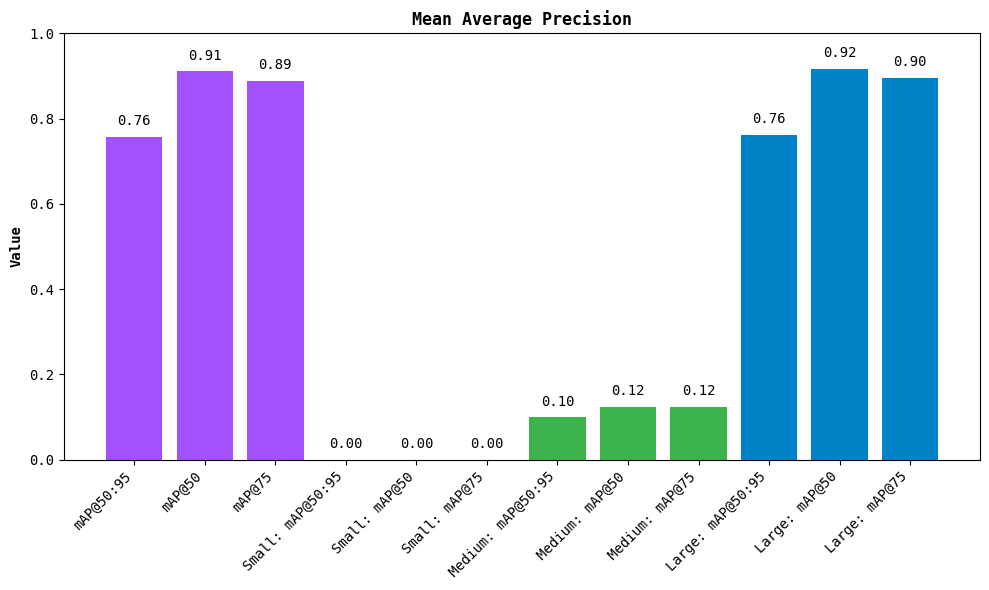

In [19]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [20]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

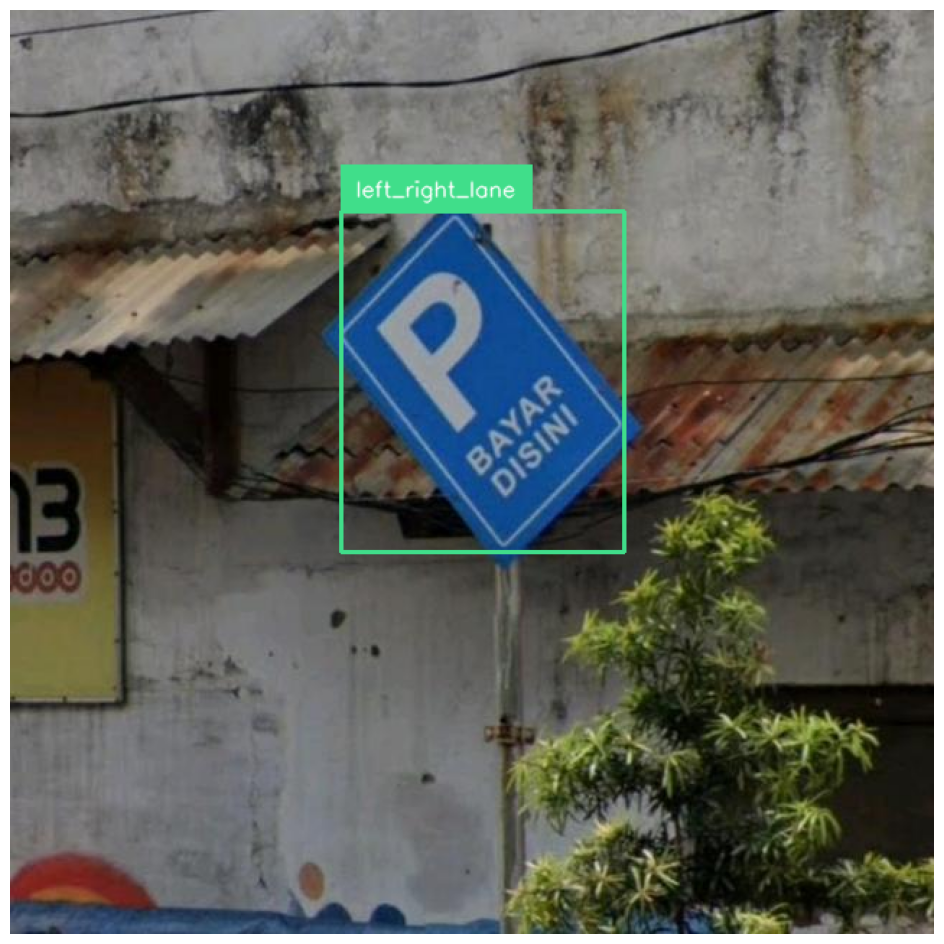

In [24]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

Saving IMG_0487_JPG.rf.dfba9cffd0691279bc1c7e3fe27a300f.jpg to IMG_0487_JPG.rf.dfba9cffd0691279bc1c7e3fe27a300f.jpg


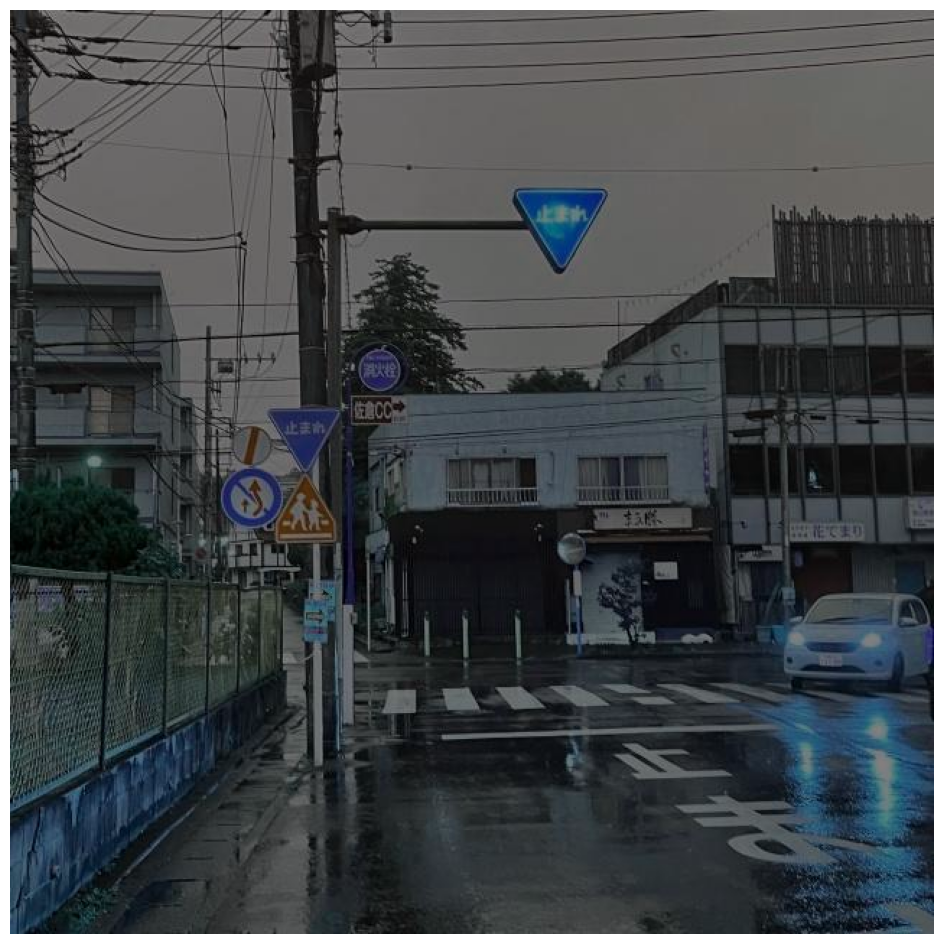

In [27]:
import random
from google.colab import files
from PIL import Image
import cv2
import supervision as sv
from ultralytics import YOLO

# 讓使用者上傳圖片
uploaded = files.upload()

# 取得圖片路徑（假設只上傳一張）
image_path = list(uploaded.keys())[0]

# 載入模型（這裡假設你已經載入好 YOLO 模型）
model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')  # 或你訓練好的模型路徑

# 使用模型做預測
results = model(image_path, verbose=False)[0]

# 取得偵測結果並做 NMS
detections = sv.Detections.from_ultralytics(results).with_nms()

# 使用 OpenCV 讀圖（因為 sv 需要 numpy 陣列）
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 畫上 bounding box 和 label
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# 顯示結果
sv.plot_image(annotated_image)

In [ ]:
import shutil
from google.colab import files

# 將 /content/runs 壓縮成 runs.zip
shutil.make_archive('/content/runs', 'zip', '/content/runs')

# 下載 runs.zip
files.download('/content/runs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
import os

# 確認資料夾存在後再刪除
runs_path = '/content/runs'
if os.path.exists(runs_path):
    shutil.rmtree(runs_path)
    print(f"{runs_path} 已成功刪除。")
else:
    print(f"{runs_path} 不存在，無需刪除。")


/content/runs 不存在，無需刪除。


In [25]:
from roboflow import download_dataset
dataset = download_dataset('https://universe.roboflow.com/yokoy-vsmht/traffic-sign-ver2.0/dataset/2', 'yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to traffic-sign-ver2.0-2 in yolov8:: 100%|██████████| 9636/9636 [00:01<00:00, 5406.40it/s]
